In [1]:
import math
import gym
import random
import itertools

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

In [2]:
class QLearner:
    def __init__(self, params):
        self.environment = gym.make('CartPole-v1')
        self.attempt_no = 1
        self.upper_bounds = [
            self.environment.observation_space.high[0],
            0.5,
            self.environment.observation_space.high[2],
            math.radians(50)
        ]
        self.lower_bounds = [
            self.environment.observation_space.low[0],
            -0.5,
            self.environment.observation_space.low[2],
            -math.radians(50)
        ]
        self.q = {}
        self.buckets = params["buckets"]
        self.a = params["a"]
        self.y = params["y"]
        self.e = params["e"]
        
        self.a_m = params["a_m"]
        self.y_m = params["y_m"]
        self.e_m = params["e_m"]


    def learn(self, max_attempts):
        for _ in range(max_attempts):
            yield self.attempt()
        
            self.a *= self.a_m ** (1/max_attempts)
            self.y *= self.y_m ** (1/max_attempts)
            self.e *= self.e_m ** (1/max_attempts)


    def attempt(self):
        observation = self.discretise(self.environment.reset())
        done = False
        reward_sum = 0.0
        
        while not done:
            action = self.pick_action(observation)
            new_observation, reward, done, info = self.environment.step(action)
            new_observation = self.discretise(new_observation)
            self.update_knowledge(action, observation, new_observation, reward)
            observation = new_observation
            reward_sum += reward
            
        self.attempt_no += 1
        return reward_sum

    def discretise(self, observation):
        res = []

        for (b, o, l, u) in zip(self.buckets, observation, self.lower_bounds, self.upper_bounds):
            clamp = lambda l, x, u: max(min(u, x), l)  

            r = b * clamp(0.0, (o - l) / (u - l), 1.0)
            res.append(int(r))

        return tuple(res) 

    def pick_action(self, observation):
        if random.random() < self.e:
            return random.choice([0, 1])

        actions = [self.q.get((observation, i), 0.0) for i in [0, 1]]
        return actions.index(max(actions))

    def update_knowledge(self, action, observation, new_observation, reward):
        new = reward + self.y * max(
            [self.q.get((new_observation, i), 0.0) for i in [0, 1]]
        )
        self.q[(observation, action)] = (1 -self.a) * self.q.get((observation, action), 0.0)  + self.a * new



In [11]:
class SARSA:
    def __init__(self, params):
        self.environment = gym.make('CartPole-v1')
        self.attempt_no = 1
        self.upper_bounds = [
            self.environment.observation_space.high[0],
            0.5,
            self.environment.observation_space.high[2],
            math.radians(50)
        ]
        self.lower_bounds = [
            self.environment.observation_space.low[0],
            -0.5,
            self.environment.observation_space.low[2],
            -math.radians(50)
        ]
        self.q = {}
        self.buckets = params["buckets"]
        self.a = params["a"]
        self.y = params["y"]
        self.e = params["e"]
        
        self.a_m = params["a_m"]
        self.y_m = params["y_m"]
        self.e_m = params["e_m"]


    def learn(self, max_attempts):
        for _ in range(max_attempts):
            yield self.attempt()
        
            self.a *= self.a_m ** (1/max_attempts)
            self.y *= self.y_m ** (1/max_attempts)
            self.e *= self.e_m ** (1/max_attempts)


    def attempt(self):
        observation = self.discretise(self.environment.reset())
        done = False
        reward_sum = 0.0
        
        action = self.pick_action(observation)
        
        while not done:
            new_observation, reward, done, info = self.environment.step(action)
            new_observation = self.discretise(new_observation)
            
            new_action = self.pick_action(observation)
            self.update_knowledge(action, new_action, observation, new_observation, reward)
            
            observation = new_observation
            action = new_action
            
            reward_sum += reward
            
        self.attempt_no += 1
        return reward_sum

    def discretise(self, observation):
        res = []

        for (b, o, l, u) in zip(self.buckets, observation, self.lower_bounds, self.upper_bounds):
            clamp = lambda l, x, u: max(min(u, x), l)  

            r = b * clamp(0.0, (o - l) / (u - l), 1.0)
            res.append(int(r))

        return tuple(res) 

    def pick_action(self, observation):
        if random.random() < self.e:
            return random.choice([0, 1])

        actions = [self.q.get((observation, i), 0.0) for i in [0, 1]]
        return actions.index(max(actions))

    def update_knowledge(self, action, new_action, observation, new_observation, reward):
        new = reward + \ 
        self.y * self.q.get((new_observation, new_action), 0.0) - \
        self.q.get((observation, action), 0.0)
        
        
        self.q[(observation, action)] = (1 -self.a) * self.q.get((observation, action), 0.0)  + self.a * new

In [12]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [35]:
def run(create_learner, params):
    measures = []
    for _ in range(20):
        learner = create_learner(params)
        res = running_mean([x for x in learner.learn(10000)], 50)

        measures.append(res)

    means = [
        np.mean([m[i] for m in measures])
        for i in range(len(measures[0]))
    ]
    stds = [
        np.std([m[i] for m in measures])
        for i in range(len(measures[0]))
    ]
    
    maxx = [
        np.percentile([m[i] for m in measures], 95)
        for i in range(len(measures[0]))
    ]
    
    minn = [
        np.percentile([m[i] for m in measures], 5)
        for i in range(len(measures[0]))
    ]

    x = list(range(1, len(means) + 1))
    plt.figure(figsize=(21, 13))
    
    plt.fill_between(
        x, 
        [m - s for m,s in zip(means, stds)],  
        [m + s for m, s in zip(means, stds)], 
        color="#9cff57",
        alpha=0.5,
        label="+/i stdev"
    )
    
    plt.plot(x, minn, color="#1a237e", label="5th percentile", linestyle='--', alpha=0.75)
    plt.plot(x, maxx, color="#880e4f", label="95th percentile", linestyle='--', alpha=0.75)

    plt.plot(x, means, color="#f57f17", label="mean")

    plt.xlabel("Attempt")
    plt.ylabel("Reward sum")
    plt.legend()
    plt.title(str(params))

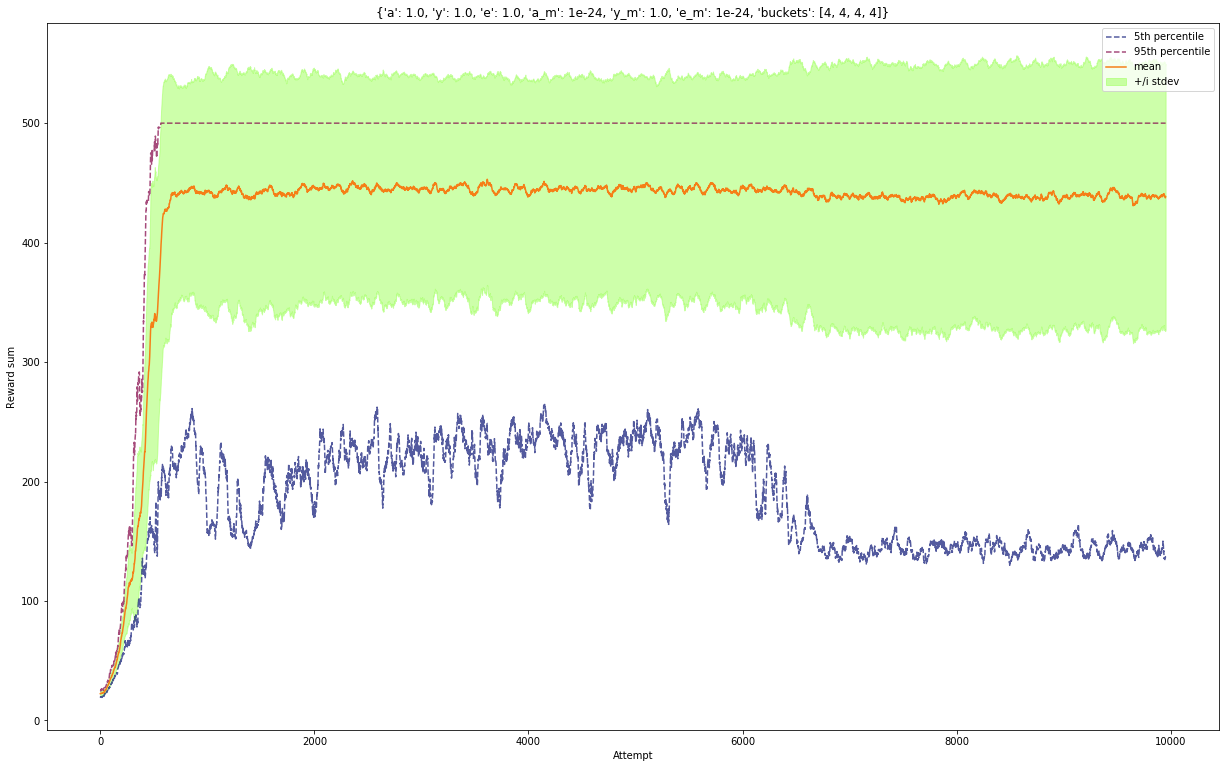

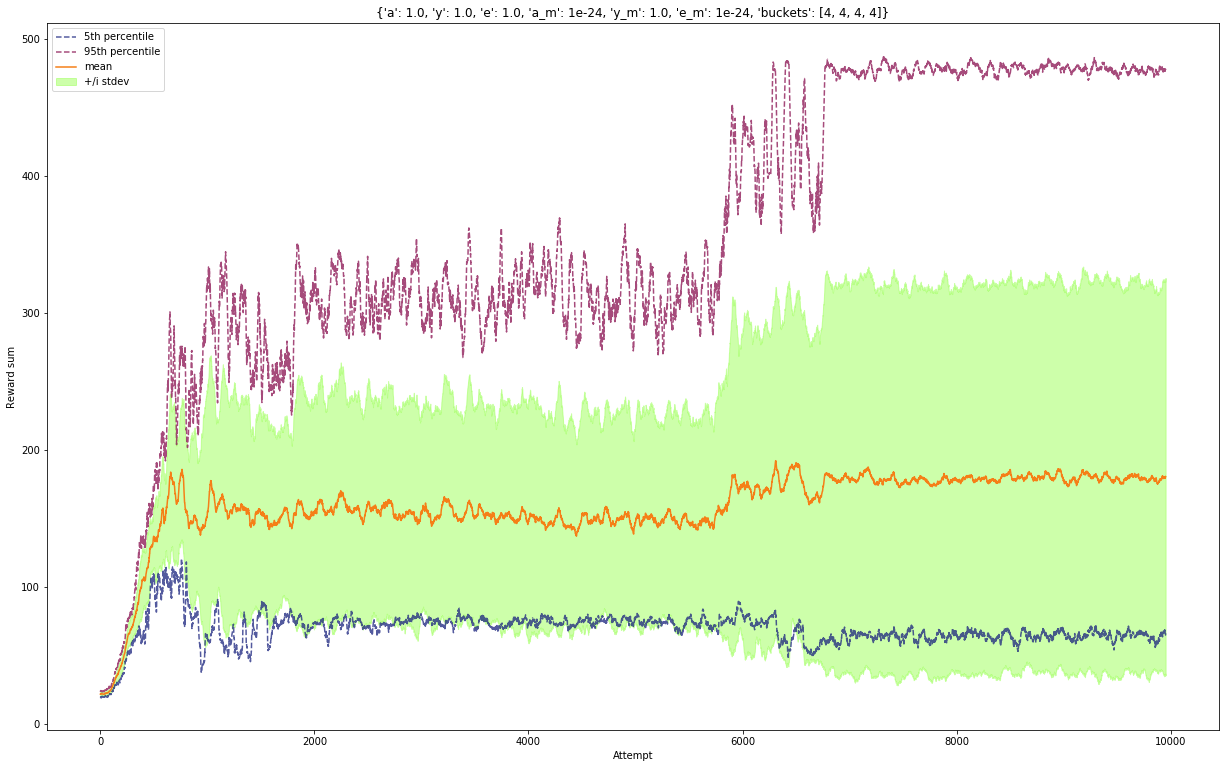

In [36]:
base_params = {
    "a":  1.0,
    "y":  1.0,
    "e":  1.0,
    
    "a_m": 0.000000000000000000000001,
    "y_m": 1.0,
    "e_m": 0.000000000000000000000001
}

run(lambda params: QLearner(params), {**base_params, "buckets": [4, 4, 4, 4]})
run(lambda params: SARSA(params), {**base_params, "buckets": [4, 4, 4, 4]})

# run({**base_params, "buckets":[2, 2, 4, 4]})
# run({**base_params, "buckets":[2, 2, 4, 4], "a_m": 0.4, "e_m": 0.4})
# run({**base_params, "buckets":[2, 2, 4, 4], "y_m": 0.99})